<a href="https://colab.research.google.com/github/ArmandDS/topic_modeling/blob/master/topic_modeling_spanish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this article we will implementing topics model with gensim, topic models are 
probabilistic models which contains information about topics in the
text. A topic is like theme, or in other words underlying ideas represented in text. 
For example, we are working with a corpus of **spanish newspaper articles**,
possible topics would be  politics, conflicts, elections and so on.

#### Load the libraries

In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


### Connect to drive to get the data

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
df_news = pd.read_csv("/content/gdrive/My Drive/text_summarization/df_news_20minutos.csv")
df_news.head(2)

,Unnamed: 0,title,summary,text,link,date
0,0,"Trump acusa a Twitter de ""sesgo"": ""Antes ganab...","""Debería tener millones y millones de seguido...","El presidente estadounidense, Donald Trump, s...",https://www.20minutos.es/noticia/3700999/0/tru...,2019-07-12
1,1,El Gobierno de Venezuela y la oposición crean ...,Las dos partes comenzaron esta semana una neg...,El gobernador del estado venezolano de Mirand...,https://www.20minutos.es/noticia/3701008/0/ven...,2019-07-12


In [8]:
df_news.drop('Unnamed: 0', inplace=True, axis=1)
df_news.dropna(inplace=True)
df_news.shape

(46898, 5)

In [9]:
df_news.head()

,title,summary,text,link,date
0,"Trump acusa a Twitter de ""sesgo"": ""Antes ganab...","""Debería tener millones y millones de seguido...","El presidente estadounidense, Donald Trump, s...",https://www.20minutos.es/noticia/3700999/0/tru...,2019-07-12
1,El Gobierno de Venezuela y la oposición crean ...,Las dos partes comenzaron esta semana una neg...,El gobernador del estado venezolano de Mirand...,https://www.20minutos.es/noticia/3701008/0/ven...,2019-07-12
2,Mueren más de cien niños en dos meses por sara...,El brote afecta a un campo de desplazados en ...,Las autoridades de la República Democrática d...,https://www.20minutos.es/noticia/3701012/0/mue...,2019-07-12
3,El Gobierno de Japón pide perdón por discrimin...,"El primer ministro ofrece una ""sincera discul...","El primer ministro nipón, Shinzo Abe, pidió e...",https://www.20minutos.es/noticia/3701021/0/jap...,2019-07-12
4,Espectacular abordaje de la Guardia Costera de...,"En el vídeo difundido por la Guardia Costera,...",La Guardia Costera de EE UU ha interceptado u...,https://www.20minutos.es/noticia/3701079/0/gua...,2019-07-12


In [10]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46898 entries, 0 to 47029
Data columns (total 5 columns):
title      46898 non-null object
summary    46898 non-null object
text       46898 non-null object
link       46898 non-null object
date       46898 non-null object
dtypes: object(5)
memory usage: 2.1+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

In [0]:
black_list = ['más', 'mas', 'unir', 'paises', 'pais', 'espa', 'no', 'os', 'a', 'compa', 'acompa', 'off', 'and', 'grecia', 'the','it', 'to',
              'd',  'et',  'dame',  'il',  'dans', 'that',  'as',   'for',  'it',  'elections',  'would',  'this',  'with', 'york', 'obama', 'chavez', 'gadafi']

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [0]:
def cleaner(word):
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
  word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
  word = re.sub(r'ee.uu', 'eeuu', word)
  word = re.sub(r'\#\.', '', word)
  word = re.sub(r'\n', '', word)
  word = re.sub(r',', '', word)
  word = re.sub(r'\-', ' ', word)
  word = re.sub(r'\.{3}', ' ', word)
  word = re.sub(r'a{2,}', 'a', word)
  word = re.sub(r'é{2,}', 'é', word)
  word = re.sub(r'i{2,}', 'i', word)
  word = re.sub(r'ja{2,}', 'ja', word) 
  word = re.sub(r'á', 'a', word)
  word = re.sub(r'é', 'e', word)
  word = re.sub(r'í', 'i', word)
  word = re.sub(r'ó', 'o', word)
  word = re.sub(r'ú', 'u', word)  
  word = re.sub('[^a-zA-Z]', ' ', word)
  list_word_clean = []
  for w1 in word.split(" "):
    if  w1.lower() not in stopwords:
      list_word_clean.append(w1.lower())

  bigram_list = bigram[list_word_clean]
  out_text = lemmatization(" ".join(bigram_list))
  return out_text

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

In [0]:
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

For gensim we need a list of text, so we need do convert the dataframe to list

In [14]:
len(df_news.text.to_list())

46898

Then we look for bigram in our data, i.e pair of words that together have more meanful for our model

In [15]:
%%time
bigram = gensim.models.Phrases(df_news.text.to_list()) 

CPU times: user 2min 46s, sys: 21 ms, total: 2min 46s
Wall time: 2min 46s


Let's examine some output

In [16]:
bigram[df_news.text.to_list()[20000].split()]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['La',
 'Policía',
 'italiana',
 'ha',
 'detenido',
 'este',
 'martes',
 'a',
 'ocho',
 'personas;',
 'tres',
 'marroquíes,',
 'un',
 'sirio',
 'y',
 'cuatro',
 'libios,',
 'acusados',
 'de',
 'ser',
 'los',
 'presuntos',
 'traficantes',
 'que',
 'viajaban',
 'en',
 'el',
 'barco',
 'donde',
 'encontraron',
 'a',
 '49',
 'inmigrantes',
 'muertos',
 'el',
 'pasado',
 '15',
 'de',
 'agosto,',
 'ha',
 'informado',
 'la',
 'fiscalía',
 'de',
 'Catania',
 '(Sicilia).',
 'Los',
 'detenidos,',
 'de',
 'entre',
 '18',
 'y',
 '30',
 'años,',
 'acusados',
 'de',
 'inmigración',
 'clandestina',
 'y',
 'homicidio,',
 'han',
 'sido',
 'reconocidos',
 'por',
 'algunas',
 'de',
 'las',
 '300',
 'personas',
 'que',
 'viajaban',
 'en',
 'esta',
 'nave,',
 'como',
 'la',
 'tripulación',
 'encargada',
 'de',
 'conducirles',
 'desde',
 'Libia',
 'a',
 'las',
 'costas',
 'italianas,',
 'añade',
 'el',
 'comunicado',
 'de',
 'la',
 'fiscalía',
 'siciliana.',
 'Los',
 'cadáveres',
 'fueron',
 'hallados,',
 '

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

additional_stopwords=set(black_list)

stopwords = stop.union(additional_stopwords)

We are using Spacy For lemmatize spanish words

In [19]:
!python -m spacy download es_core_news_md

     |████████████████████████████████| 73.4MB 106.7MB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.1.0-cp36-none-any.whl size=74602272 sha256=5593dd2852f639dc6a2c9eb537d1fd5f4691634475d02ff417be990ef122ea0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-mlf20pf6/wheels/20/f7/6b/7a1ba56f009b05386d123ea088b56635594a046acd5cfdd2a2
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [0]:
import spacy
nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/es_core_news_md/es_core_news_md-2.1.0')

Now let's test the cleaner function:

In [21]:
df_news.text[0]

' El presidente estadounidense, Donald Trump, se quejó este jueves de lo que percibe como una pérdida de seguidores y de influencia de sus mensajes diarios en Twitter, y acusó a esa red social y otros gigantes de Internet de mostrar un "sesgo terrible" contra las ideas conservadoras. Durante una "cumbre sobre redes sociales" llena de activistas conservadores, Trump aseguró que invitará a representantes de esas compañías a reunirse con él en algún momento de las próximas semanas para airear de nuevo sus quejas contra Google, Twitter, Facebook y otros gigantes de Internet. "No tengo ninguna duda de que debería tener millones y millones de seguidores, pero nos bloquean", denunció Trump durante la cumbre, celebrada en la sala Este de la Casa Blanca. El mandatario, que tiene casi 62 millones de seguidores en Twitter, se quejó de que ese número fluctúa, algo que probablemente se deba a que la red social efectúa en ocasiones purgas para eliminar cuentas falsas o bots, lo que también ha llevad

In [22]:
cleaner(df_news.text[0])


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['presidente',
 'trump',
 'quejo',
 'jueves',
 'seguidores',
 'influencia',
 'mensajes',
 'red',
 'internet',
 'sesgo',
 'ideas',
 'cumbre',
 'redes',
 'activistas',
 'trump',
 'representantes',
 'momento',
 'semanas',
 'quejas',
 'facebook',
 'internet',
 'duda',
 'millones',
 'millones',
 'trump',
 'cumbre',
 'sala',
 'casa',
 'mandatario',
 'millones',
 'seguidores',
 'twitter',
 'quejo',
 'red',
 'ocasiones',
 'cuentas',
 'bots',
 'seguidores',
 'ejemplo',
 'gente',
 'advirtio',
 'trump',
 'seguidores',
 'veces',
 'trump',
 'presidente',
 'herramientas',
 'gobierno',
 'red',
 'prueba',
 'mensajes',
 'medios',
 'anuncio',
 'red',
 'seguidores',
 'subia',
 'lindezas',
 'cohete',
 'trump',
 'quejo',
 'cifra',
 'tambien',
 'faltas',
 'menudo',
 'tuits',
 'corregidos',
 'ortografia',
 'cerebro',
 'mandatario',
 'asistentes',
 'cumbre',
 'activistas',
 'redes',
 'duo',
 'diamond',
 'guardianes',
 'medios',
 'ciudadanos',
 'filtro',
 'medios',
 'trump',
 'libertad',
 'prensa',
 'tipo',
 '

The Cleaner function work properly

##### Let's clean all the text

In [0]:
df_news['text2'] = df_news['text']

In [24]:
%%time
df_news['text'] = df_news['text'].apply(cleaner)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 30min 47s, sys: 28.1 s, total: 31min 15s
Wall time: 31min 15s


Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [0]:
dictionary = Dictionary(df_news['text'].to_list())
dictionary.compactify()
# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['text'].to_list()]

# Now let's do the modeling part

We are comparing 3 topic modeling algorithm Latent Dirichlet Allocation (LDA), Latent
semantic analysis (LSA), Hierarchical Dirichlet Process
(HDP),in order to evaluate topic models we will be using **topic coherence**, which is a measure of how
interpretable topics are for human beings.

 ## Hierarchical Dirichlet process Model

In [0]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

and the topics of this model:

In [0]:
def display_topics(model, model_type="lda"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx))
    if model_type== "hdp":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")
    



In [28]:
# hdpmodel.show_topics() 

display_topics(hdpmodel, model_type="hdp")

Topic 0:
gobierno  presidente  personas  ministro  millones  parte  partido  acuerdo  seguridad  elecciones 

Topic 1:
personas  ciudad  seguridad  autoridades  gobierno  parte  policia  millones  zona  grupo 

Topic 2:
presidente  gobierno  personas  seguridad  parte  trump  ministro  fuerzas  millones  autoridades 

Topic 3:
gobierno  presidente  personas  caso  parte  ministro  policia  millones  seguridad  autoridades 

Topic 4:
personas  policia  autoridades  mujer  ciudad  despues  parte  lugar  hombre  momento 

Topic 5:
personas  policia  autoridades  ciudad  zona  hora  lugar  momento  mujer  hombre 

Topic 6:
presidente  gobierno  caso  partido  personas  grupo  autoridades  ministro  euros  parte 

Topic 7:
personas  kilometros  policia  ciudad  zona  autoridades  hora  muerte  momento  horas 

Topic 8:
personas  autoridades  acuerdo  gobierno  parte  momento  caso  presidente  policia  millones 

Topic 9:
partido  presidente  grupo  gobierno  elecciones  ministro  votos  pa

as we could see there are 20 topics, however is kind of dificult to interpret or follow, so we decide to move to another model.





In [0]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

##LSI MODEL

In [0]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [31]:
display_topics(lsimodel)  # Showing the topics

Topic 0:
presidente gobierno personas ministro seguridad parte atentados venezuela policia trump 

Topic 1:
presidente atentados venezuela trump personas policia gobierno elecciones juan seguridad 

Topic 2:
millones trump atentados presidente gobierno euros acuerdo venezuela parte paris 

Topic 3:
trump venezuela gobierno juan millones nicolas votos elecciones casa clinton 

Topic 4:
personas atentados ministro partido gobierno accidente acuerdo venezuela avion paris 

Topic 5:
accidente avion alpes millones personas ministro vuelo familiares horas partido 

Topic 6:
millones partido elecciones presidente personas euros atentados votos policia ataque 

Topic 7:
millones personas seguridad acuerdo partido gobierno elecciones ataque trump armas 

Topic 8:
personas presidente mujeres bruselas caso acuerdo venezuela partido mujer libertad 

Topic 9:
bruselas presidente aeropuerto gobierno trump marzo venezuela atentados metro martes 



It seen that with 10 topics there is some themes with keywords related to: trump, venezuela, police, electiones, terrorism; still is a little difficult to gt some insight, because of this we are trying to select the best number of topics by iterate over a range of values and looking the coherence 

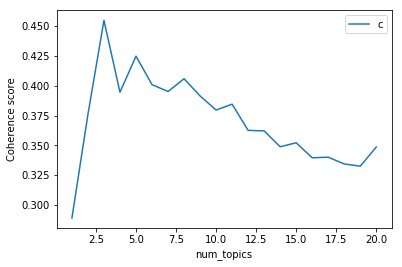

CPU times: user 6min 40s, sys: 1min 50s, total: 8min 31s
Wall time: 9min 42s


In [32]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['text'].to_list(), limit=21, model= "lsi")

According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.


In [56]:
display_topics(lmlist_lsi[2])

Topic 0:
presidente gobierno personas ministro seguridad atentados parte venezuela trump policia 

Topic 1:
presidente atentados venezuela trump policia personas gobierno juan paris ataques 

Topic 2:
trump venezuela gobierno juan nicolas casa clinton votos noviembre elecciones 



Now, Let's try another model

## Latent Dirichlet Allocation Model

In [0]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [34]:

display_topics(ldamodel)

Topic 0:
agua personas tierra terremoto kilometros salud grados estudio zona metros 

Topic 1:
ciudad personas policia autoridades horas hora aeropuerto noche mineros servicio 

Topic 2:
mundo mujeres vida papa universidad personas vez mujer iglesia trabajo 

Topic 3:
gobierno ministro ley partido parlamento acuerdo union reforma diputados consejo 

Topic 4:
personas policia ciudad fuentes seguridad zona autoridades lugar centro horas 

Topic 5:
millones euros dolares gobierno medidas crisis parte empresas dinero sector 

Topic 6:
seguridad huelga avion tropas vuelos soldados mision gobierno aviones aeropuerto 

Topic 7:
gobierno presidente fuerzas seguridad protestas pueblo consejo parte grupo paz 

Topic 8:
presidente partido ministro elecciones gobierno casa domingo candidato cumbre jefe 

Topic 9:
caso muerte mujer justicia juez familia tribunal casa despues juicio 



Find out the optimal number of topics for the LDA model based on the coherence metric:

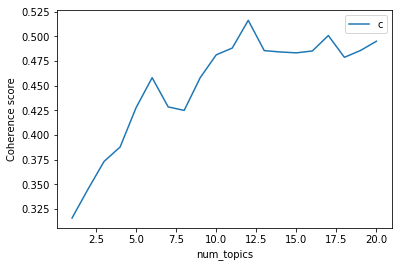

CPU times: user 12min 35s, sys: 1min 14s, total: 13min 50s
Wall time: 22min 45s


In [35]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['text'].to_list(), limit=21, model= "lda")

For this model it seems that  9 or 18, again we must to check the keywords too.

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [0]:

ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [0]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['text'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['text'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['text'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

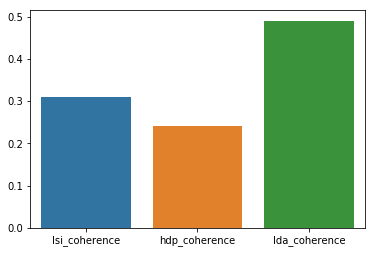

In [59]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)


We can see that the **LdaModel** model **with 8 topics** has the higher value of
coherence

Examine the keyword to get the topics of the best model

In [60]:

display_topics(ldamodel)

Topic 0:
derechos humanos muerte guerra tribunal juez caso libertad personas juicio 

Topic 1:
estudio tierra universidad mundo agua investigadores cambio expertos corea sistema 

Topic 2:
policia hombre casa mujer muerte familia hospital autoridades caso despues 

Topic 3:
presidente gobierno ministro justicia mubarak pueblo presos venezuela jefe caso 

Topic 4:
mujeres mundo mujer papa vida iglesia matrimonio caso hombres casos 

Topic 5:
personas metros rescate zona autoridades isla mar kilometros agua horas 

Topic 6:
partido presidente elecciones votos gobierno candidato comicios partidos domingo ministro 

Topic 7:
personas seguridad fuerzas ciudad ataque policia fuentes grupo ataques protestas 

Topic 8:
millones euros gobierno dolares medidas crisis parte empresas trabajo sector 

Topic 9:
personas terremoto ayuda ciudad seismo zonas zona millones agua muertos 

Topic 10:
gobierno presidente ministro consejo acuerdo seguridad parte paz union asuntos 

Topic 11:
aeropuerto avion

It looks like the topics are:
* Topic 0: is about trials (justice)
* Topic 1: is like nature studies
* Topic 2: is about violence (against women maybe?)
* Topic 3: protest and disturb (like venezuelan case)
* Topic 4: is about life and family
* Topic 5: sea disasters
* Topic 6: elections
* Topic 7: is about terrorism
* Topic 8: is about economic crisis
* Topic 9: is like seism studies
* Topic 10: is about peacy treaty
* Topic 11: airport and security


Let´s check the keyword when we selecting another number of topics (14)

In [0]:
ldamodel_16 =lmlist[16]


In [41]:
display_topics(ldamodel_16)

Topic 0:
presidente casa washington congreso barack informacion documentos inteligencia seguridad programa 

Topic 1:
gobierno ministro partido parlamento union acuerdo crisis presidente consejo parte 

Topic 2:
millones euros dolares gobierno ley dinero empresas medidas parte proyecto 

Topic 3:
personas ciudad centro policia seguridad plaza lugar autoridades atentado edificio 

Topic 4:
partido elecciones votos candidato presidente comicios domingo victoria resultados vuelta 

Topic 5:
fuerzas seguridad ataque grupo soldados ataques ciudad guerra personas gobierno 

Topic 6:
mujer familia vida padre madre hijo hijos casa hospital mundo 

Topic 7:
policia muerte personas hombre autoridades caso mujer asesinato agentes juez 

Topic 8:
estudio millones mundo informe personas agua datos salud nivel parte 

Topic 9:
mujeres papa iglesia casos caso abusos personas parte derechos matrimonio 

Topic 10:
presidente gobierno seguridad paz ministro consejo acuerdo parte asuntos naciones 

Topic

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [0]:
def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['text'].to_list())



In [66]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5252,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, quejo, jueves, seguidores,..."
1,1,10.0,0.6767,"gobierno, presidente, ministro, consejo, acuer...","[gobernador, hector, conversaciones, gobierno,..."
2,2,9.0,0.4595,"personas, terremoto, ayuda, ciudad, seismo, zo...","[autoridades, congo, jueves, muerte, centenar,..."
3,3,8.0,0.3184,"millones, euros, gobierno, dolares, medidas, c...","[ministro, shinzo, abe, viernes, disculpas, fa..."
4,4,5.0,0.3357,"personas, metros, rescate, zona, autoridades, ...","[guardia, submarino, kilos, aguas, abordaje, s..."
5,5,2.0,0.5224,"policia, hombre, casa, mujer, muerte, familia,...","[condado, ohio, sentencia, profesora, contacto..."
6,6,10.0,0.6356,"gobierno, presidente, ministro, consejo, acuer...","[gobierno, kyriakos, viernes, presidente, parl..."
7,7,3.0,0.4092,"presidente, gobierno, ministro, justicia, muba...","[barco, watch, carola, inmigrantes, viernes, q..."
8,8,5.0,0.3907,"personas, metros, rescate, zona, autoridades, ...","[policia, viernes, tripulantes, grace, capitan..."
9,9,6.0,0.5685,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, viernes, gobierno, domingo..."


We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [0]:
label_dicc = {0:'trials', 1:'nature', 2:'violence', 3: 'protest', 4:'life_family', 5:'sea_disasters', 6:'elections', 
              7:'terrorism', 8:'economic_crisis', 9: 'seism', 10:'peacy_treaty', 11:'airport_security'}

In [0]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [69]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,elections,0.5252,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, quejo, jueves, seguidores,..."
1,1,peacy_treaty,0.6767,"gobierno, presidente, ministro, consejo, acuer...","[gobernador, hector, conversaciones, gobierno,..."
2,2,seism,0.4595,"personas, terremoto, ayuda, ciudad, seismo, zo...","[autoridades, congo, jueves, muerte, centenar,..."
3,3,economic_crisis,0.3184,"millones, euros, gobierno, dolares, medidas, c...","[ministro, shinzo, abe, viernes, disculpas, fa..."
4,4,sea_disasters,0.3357,"personas, metros, rescate, zona, autoridades, ...","[guardia, submarino, kilos, aguas, abordaje, s..."
5,5,violence,0.5224,"policia, hombre, casa, mujer, muerte, familia,...","[condado, ohio, sentencia, profesora, contacto..."
6,6,peacy_treaty,0.6356,"gobierno, presidente, ministro, consejo, acuer...","[gobierno, kyriakos, viernes, presidente, parl..."
7,7,protest,0.4092,"presidente, gobierno, ministro, justicia, muba...","[barco, watch, carola, inmigrantes, viernes, q..."
8,8,sea_disasters,0.3907,"personas, metros, rescate, zona, autoridades, ...","[policia, viernes, tripulantes, grace, capitan..."
9,9,elections,0.5685,"partido, presidente, elecciones, votos, gobier...","[presidente, trump, viernes, gobierno, domingo..."


In [0]:
df_news['labels'] = df_dominant_topic['Dominant_Topic']


Let's examine some text and its topics

In [74]:
df_news[['text2', 'labels']].head(10)

,text2,labels
0,"El presidente estadounidense, Donald Trump, s...",elections
1,El gobernador del estado venezolano de Mirand...,peacy_treaty
2,Las autoridades de la República Democrática d...,seism
3,"El primer ministro nipón, Shinzo Abe, pidió e...",economic_crisis
4,La Guardia Costera de EE UU ha interceptado u...,sea_disasters
5,"Una jueza del condado de Hamilton (Ohio, EE U...",violence
6,El nuevo Gobierno griego del conservador Kyri...,peacy_treaty
7,La capitana del barco humanitario Sea Watch 3...,protest
8,La Policía de Gibraltar ha detenido este vier...,sea_disasters
9,"El presidente de Estados Unidos, Donald Trump...",elections


In [48]:
df_news[ df_news['labels'] == 'family'].head().text2

5      Una jueza del condado de Hamilton (Ohio, EE U...
7      La capitana del barco humanitario Sea Watch 3...
10     Un bebé de un año ha muerto en la localidad f...
12     Una mujer de Nueva York denunció este miércol...
14     El fiscal general venezolano, Tarek Saab, inf...
Name: text2, dtype: object

### let's see the distribution of topics


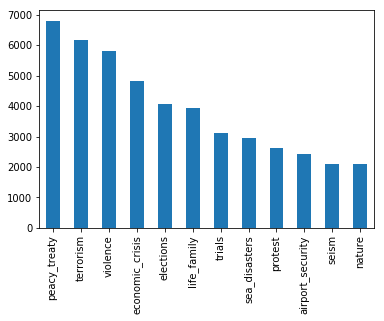

In [75]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [50]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=92c312b5ac7db0b39960145bda19f138176d167cc43be944e15963af9fb0347f
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [0]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [78]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.164616 -0.039300       1        1  15.092861
7     -0.094997  0.150723       2        1  11.203745
8      0.081717 -0.172475       3        1  10.792636
6      0.209895 -0.029190       4        1   9.424135
2     -0.046365  0.175446       5        1   9.155202
4      0.050707  0.041558       6        1   7.767630
0      0.053810  0.083899       7        1   7.560819
3      0.150874  0.095943       8        1   7.209678
5     -0.188604 -0.003763       9        1   6.290334
9     -0.150967 -0.077836      10        1   5.600895
1     -0.067910 -0.221784      11        1   5.066353
11    -0.162777 -0.003220      12        1   4.835713, topic_info=      Category          Freq         Term         Total  loglift  logprob
44     Default  37172.000000   presidente  37172.000000  30.0000  30.0000
42     Default  15402.000000      partido  15402.000000  29.0000  29.0000
38     Default  21162.000000     millones  21162.000000  28.0000  28.0000
87     Default  10230.000000   elecciones  10230.000000  27.0000  27.0000
172    Default  30382.000000     personas  30382.000000  26.0000  26.0000
278    Default  13790.000000      policia  13790.000000  25.0000  25.0000
207    Default  10019.000000        euros  10019.000000  24.0000  24.0000
691    Default  13704.000000      fuerzas  13704.000000  23.0000  23.0000
25     Default  39332.000000     gobierno  39332.000000  22.0000  22.0000
275    Default   7521.000000      mujeres   7521.000000  21.0000  21.0000
911    Default   7960.000000     derechos   7960.000000  20.0000  20.0000
357    Default  21484.000000    seguridad  21484.000000  19.0000  19.0000
491    Default  15885.000000       ciudad  15885.000000  18.0000  18.0000
1361   Default   4092.000000   aeropuerto   4092.000000  17.0000  17.0000
274    Default   7686.000000        mujer   7686.000000  16.0000  16.0000
215    Default  23000.000000     ministro  23000.000000  15.0000  15.0000
1697   Default   4611.000000        votos   4611.000000  14.0000  14.0000
1364   Default   3319.000000        avion   3319.000000  13.0000  13.0000
476    Default  10630.000000         zona  10630.000000  12.0000  12.0000
577    Default   7389.000000       ataque   7389.000000  11.0000  11.0000
917    Default   4632.000000      humanos   4632.000000  10.0000  10.0000
624    Default   3431.000000    accidente   3431.000000   9.0000   9.0000
169    Default  10689.000000       muerte  10689.000000   8.0000   8.0000
142    Default  15894.000000  autoridades  15894.000000   7.0000   7.0000
78     Default   9437.000000      consejo   9437.000000   6.0000   6.0000
2052   Default   4979.000000      rescate   4979.000000   5.0000   5.0000
955    Default   5137.000000         agua   5137.000000   4.0000   4.0000
73     Default   3646.000000    candidato   3646.000000   3.0000   3.0000
2246   Default   3213.000000         papa   3213.000000   2.0000   2.0000
456    Default   6633.000000       hombre   6633.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
9232   Topic12    348.048676      subasta    362.547974   2.9883  -6.3464
771    Topic12   1318.559082   transporte   1921.118286   2.6528  -5.0145
1667   Topic12    454.936066  transportes    549.985474   2.8394  -6.0786
2633   Topic12    461.461609   accidentes    564.017700   2.8285  -6.0644
2486   Topic12   1398.079102      aviones   2365.981201   2.5030  -4.9559
256    Topic12    629.338440    velocidad    858.888550   2.7182  -5.7541
217    Topic12    652.947327    pacientes    969.692871   2.6337  -5.7173
6194   Topic12    333.069916     billetes    387.221069   2.8785  -6.3904
205    Topic12   1040.928467   enfermedad   2021.097900   2.3656  -5.2509
11876  Topic12    605.434998    reactores    960.900635   2.5672  -5.7928
430    Topic12   2399.885254        horas  13028.529297   1.3374  -4.4156
685    Topic12    7